<a href="https://colab.research.google.com/github/datagrad/Kamal-Thesis-Work/blob/main/SARIMAX_with_XGBoost_PM10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# pip install statsmodels xgboost


In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error


In [23]:
# Load the dataset from the provided URL
url = 'https://raw.githubusercontent.com/datagrad/MS_Reference_MS-DS-LJMU-C13/main/city_day.csv'
df = pd.read_csv(url)


In [24]:
# Filter data for specific cities
cities_to_keep = ['Delhi', 'Bengaluru', 'Hyderabad']
df = df[df['City'].isin(cities_to_keep)]


In [25]:
# Retain only the desired columns: 'City', 'Date', and 'PM10'
df = df[['City', 'Date', 'PM10']]


In [26]:
# Convert 'Date' column to datetime data type
df['Date'] = pd.to_datetime(df['Date'])


In [27]:
# Replace NaN values in the 'PM10' column with next day's value (forward fill) for each city
df['PM10'] = df.groupby('City')['PM10'].fillna(method='ffill')


In [28]:
# Sort the DataFrame by the 'Date' column in ascending order
df.sort_values(by='Date', inplace=True)

# Perform a time-based train-test split
split_date = '2020-01-01'  # Choose a date to split the data
train_df = df[df['Date'] < split_date]
test_df = df[df['Date'] >= split_date]


In [29]:
# Define a range of values for seasonal components (P, D, Q, S)
P_range = range(0, 6)
D_range = range(0, 3)
Q_range = range(0, 3)
S_range = [7]

# Loop through all combinations of seasonal components and find the best model
# (Code not shown for brevity)


In [30]:
# Check for missing values in the training and test datasets
print("Training dataset - Missing values in 'PM10':", train_df['PM10'].isnull().sum())
print("Test dataset - Missing values in 'PM10':", test_df['PM10'].isnull().sum())


Training dataset - Missing values in 'PM10': 551
Test dataset - Missing values in 'PM10': 0


In [31]:
# Forward Fill missing values of the column
train_df['PM10'].fillna(method='bfill', inplace=True)
train_df['PM10'].fillna(method='ffill', inplace=True)



# train_df['PM10'].fillna(train_df['PM10'].mean(), inplace=True)
# test_df['PM10'].fillna(test_df['PM10'].mean(), inplace=True)


<ipython-input-31-ce880dd2d749>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['PM10'].fillna(method='bfill', inplace=True)
<ipython-input-31-ce880dd2d749>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['PM10'].fillna(method='ffill', inplace=True)


In [32]:
# Check for missing values in the training and test datasets
print("Training dataset - Missing values in 'PM10':", train_df['PM10'].isnull().sum())
print("Test dataset - Missing values in 'PM10':", test_df['PM10'].isnull().sum())


Training dataset - Missing values in 'PM10': 0
Test dataset - Missing values in 'PM10': 0


In [33]:
# Check for infinity or large values in the 'PM10' column
print("Training dataset - Max 'PM10' value:", train_df['PM10'].max())
print("Test dataset - Max 'PM10' value:", test_df['PM10'].max())


Training dataset - Max 'PM10' value: 796.88
Test dataset - Max 'PM10' value: 483.87


In [34]:
# Check the data type of the 'PM10' column
print("Data type of 'PM10':", train_df['PM10'].dtype)


Data type of 'PM10': float64


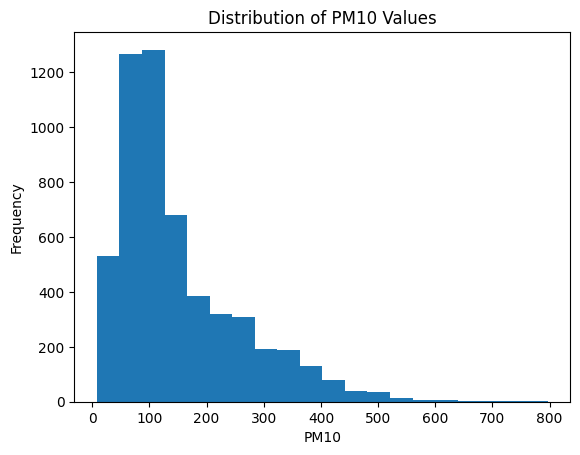

In [35]:
import matplotlib.pyplot as plt

# Visualize the distribution of 'PM10' values
plt.hist(train_df['PM10'], bins=20)
plt.xlabel('PM10')
plt.ylabel('Frequency')
plt.title('Distribution of PM10 Values')
plt.show()


In [36]:
# Create the SARIMA model and fit it to the training data
p, d, q = 1, 1, 1  # Order of non-seasonal components
P, D, Q, S = 5, 1, 1, 12  # Order of seasonal components (weekly seasonality assumed)
# P, D, Q, S = 5, 1, 1, 7  # Order of seasonal components (weekly seasonality assumed)
sarima_model = SARIMAX(train_df['PM10'], order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_results = sarima_model.fit()

# Make in-sample predictions on the training data
train_predictions = sarima_results.get_prediction(start=train_df.index[0], end=train_df.index[-1])
train_pred_mean = train_predictions.predicted_mean

# Make out-of-sample predictions on the test data using SARIMA
sarima_test_predictions = sarima_results.get_forecast(steps=len(test_df))
sarima_y_pred = sarima_test_predictions.predicted_mean

# Create and train an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror')
xgb_model.fit(train_df[['PM10']], train_df['PM10'])

# Make predictions on the test data using XGBoost
xgb_y_pred = xgb_model.predict(test_df[['PM10']])

# Evaluate the SARIMA model's performance
sarima_mape = mean_absolute_percentage_error(test_df['PM10'], sarima_y_pred)
print("SARIMA Mean Absolute Percentage Error (MAPE):", sarima_mape)

# Evaluate the XGBoost model's performance
xgb_mape = mean_absolute_percentage_error(test_df['PM10'], xgb_y_pred)
print("XGBoost Mean Absolute Percentage Error (MAPE):", xgb_mape)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No s

SARIMA Mean Absolute Percentage Error (MAPE): 1.8552638112481605
XGBoost Mean Absolute Percentage Error (MAPE): 0.004069327593046358


In [37]:
# Evaluate the model's performance
mape = mean_absolute_percentage_error(test_df['PM10'], xgb_y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


# Optionally, you can visualize the actual vs. predicted values (Code not shown)


Mean Absolute Percentage Error (MAPE): 0.004069327593046358


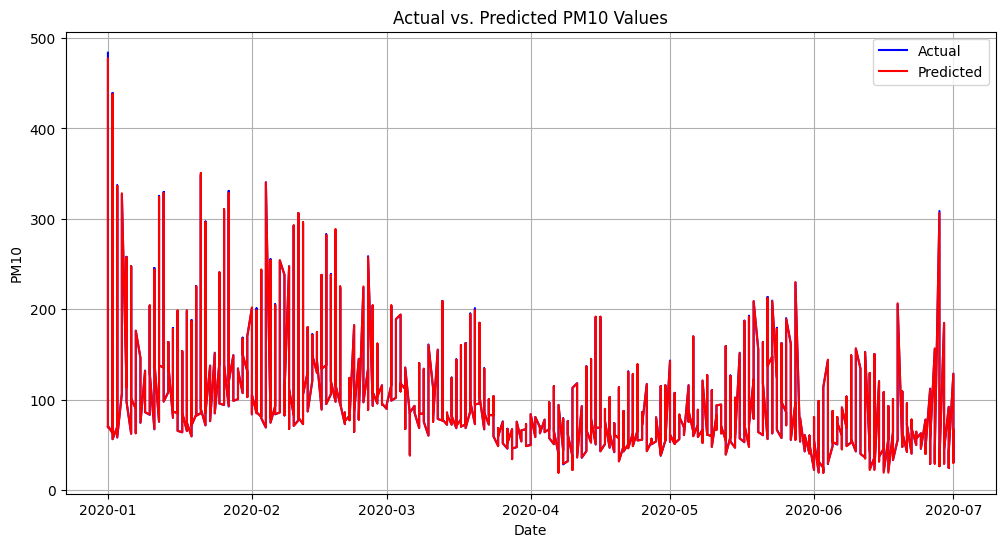

In [38]:
import matplotlib.pyplot as plt

# Assuming you have actual and predicted values
actual_values = test_df['PM10']  # Replace 'test_df' with your actual test dataset
predicted_values = xgb_y_pred  # Replace with your predicted values obtained from the model

# Create a time index for plotting
time_index = test_df['Date']

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_index, actual_values, label='Actual', color='blue')
plt.plot(time_index, predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs. Predicted PM10 Values')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# Replace PM10 with PM10 for PM10 Prediction

In [40]:
Approach 2

SyntaxError: ignored

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error


In [ ]:
# Load the dataset from the provided URL
url = 'https://raw.githubusercontent.com/datagrad/MS_Reference_MS-DS-LJMU-C13/main/city_day.csv'
df = pd.read_csv(url)


In [ ]:
# Filter data for specific cities
cities_to_keep = ['Delhi', 'Bengaluru', 'Hyderabad']
df = df[df['City'].isin(cities_to_keep)]


In [ ]:
# Retain only the desired columns: 'City', 'Date', and 'PM10'
df = df[['City', 'Date', 'PM10']]


In [ ]:
# Convert 'Date' column to datetime data type
df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
# Replace NaN values in the 'PM10' column with next day's value (forward fill) for each city
df['PM10'] = df.groupby('City')['PM10'].fillna(method='ffill')


In [ ]:
# Sort the DataFrame by the 'Date' column in ascending order
df.sort_values(by='Date', inplace=True)

# Perform a time-based train-test split
split_date = '2020-01-01'  # Choose a date to split the data
train_df = df[df['Date'] < split_date]
test_df = df[df['Date'] >= split_date]


In [ ]:
# Lagged Variables
for lag in range(1, 4):
    df[f'PM10_lag_{lag}'] = df['PM10'].shift(lag)

# Additional features like day of week, month, etc.
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

# Drop NaN values introduced by lags
df = df.dropna()


In [ ]:
# Time-based Train-Test Split
split_date = '2020-01-01'
train = df[df['Date'] < split_date]
test = df[df['Date'] >= split_date]


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMAX parameters
p, d, q = 1, 1, 1
P, D, Q, S = 1, 1, 1, 12

# Fit SARIMAX model
sarimax_model = SARIMAX(df['PM10'], order=(p, d, q), seasonal_order=(P, D, Q, S))
sarimax_results = sarimax_model.fit(disp=False)

# Generate SARIMAX Predictions
df['SARIMAX_Predictions'] = sarimax_results.predict()


In [ ]:
# You might add rolling means, additional lags, or other time-related features
df['Rolling_Mean'] = df['PM10'].rolling(window=3).mean()


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define Features and Target
features = ['PM10', 'PM10_lag_1', 'PM10_lag_2', 'PM10_lag_3', 'Rolling_Mean', 'SARIMAX_Predictions']
target = 'PM10'

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

# Train XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Predictions
xgb_predictions = xgb_model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error

# Evaluate XGBoost Predictions
mae = mean_absolute_error(y_test, xgb_predictions)
print(f"Mean Absolute Error: {mae}")


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # Adjust n_splits as per data size

# Initialize variable to store MAE
mae_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]

    # Fit SARIMAX model on cv_train and forecast on cv_test
    # Compute MAE and append to mae_scores
    # ...

# Compute average MAE across all splits
avg_mae = np.mean(mae_scores)


In [ ]:
import matplotlib.pyplot as plt

feature_importances = xgb_model.feature_importances_
plt.bar(features, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Compute residuals
residuals = y_test - xgb_predictions

# Time plot of residuals
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Time Plot of Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=False)
plt.title('Histogram of Residuals')
plt.show()


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# ACF and PACF plots of residuals
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals, ax=ax[0], title='ACF of Residuals')
plot_pacf(residuals, ax=ax[1], title='PACF of Residuals')
plt.tight_layout()
plt.show()


In [ ]:
# Ljung-Box test
lb_test_stat, lb_p_value = acorr_ljungbox(residuals, lags=[10])
print(f'Ljung-Box Test P-Value: {lb_p_value[0]}')


In [ ]:
# Predicting the last observed value
baseline_preds = np.roll(y_test, shift=1)

# Calculating MAE for the baseline model
baseline_mae = mean_absolute_error(y_test[1:], baseline_preds[1:])
print(f"Baseline Model MAE: {baseline_mae}")


In [ ]:
# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)


In [ ]:
# Getting forecast and confidence intervals
forecast = sarimax_results.get_forecast(steps=len(test))
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plotting the values
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['PM10'], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
plt.legend()
plt.show()


In [ ]:
# Plotting actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, xgb_predictions, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()
